In [1]:
import rasterio as rio
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# read data paths
directory = 'data'
files = [directory + "/" + f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f)) and f.startswith('raster')]

In [4]:
# regex function for ordering files
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else float('inf')

In [5]:
sorted_files = sorted(files, key=extract_number)

In [14]:
# initialize data cube
X = []

# read data and concatenate raster cube
start = time.time()
for n, i in enumerate(sorted_files):
    temp = rio.open(i)
    X.append(temp.read())
    temp.close()
    print(str(n+1)+"/"+str(len(sorted_files))+": "+sorted_files[n], end="\r")
X = np.concatenate(X)
end = time.time()
elapsed_time = end - start
print(f"Raster concatenation elapsed time: {elapsed_time:.2f} seconds.")

Raster concatenation elapsed time: 10.06 seconds.


In [15]:
# reduce image dimension for wavelet transform
X = X[:,:,:-3]

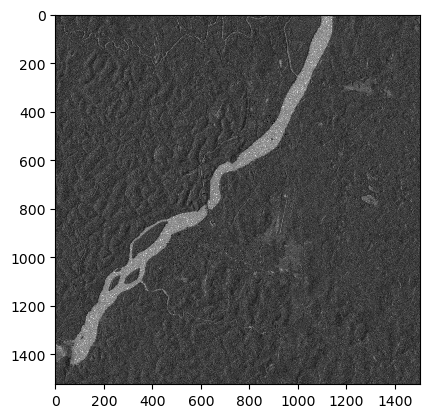

In [22]:
plt.imshow(X[0], interpolation='nearest', cmap='gray')

In [16]:
def ECS(x, smooth_x=None):
    
    assert len(x.shape) == 3, "'x' is not three-dimensional"
    mean_image = x.mean(axis=0)
    
    if smooth_x is not None:
        assert len(smooth_x.shape) == 3, "'smooth_x' is not three-dimensional"
        assert x.shape == smooth_x.shape, "'x' and 'smooth_x' are different shapes"
        cube = smooth_x.astype(np.float32)
    else:
        cube = x

    R = np.empty(mean_image.shape, np.float32)
    D = np.empty(cube.shape, np.float32)

    dims = mean_image.shape
    
    lin = dims[0]
    col = dims[1]
    
    for i in range(0, cube.shape[0]):
        D[i] = (cube[i] - mean_image)**2
    
    d = D.sum(axis=1).sum(axis=1).flatten()

    for i in range(lin):
        for j in range(col):
            R[i, j] = np.abs(np.corrcoef(d, D[:, i, j])[0][1])
    
    return R

def segment_otsu(x):
    th = threshold_otsu(x)
    binary = x > th
    binary = binary.astype('uint8')
    return binary

In [17]:
start = time.time()
wecs = ECS(X)
end = time.time()
elapsed_time = end - start
print(f"WECS elapsed time: {elapsed_time:.2f} seconds.")

WECS elapsed time: 216.67 seconds.


In [18]:
classified_wecs = segment_otsu(wecs)

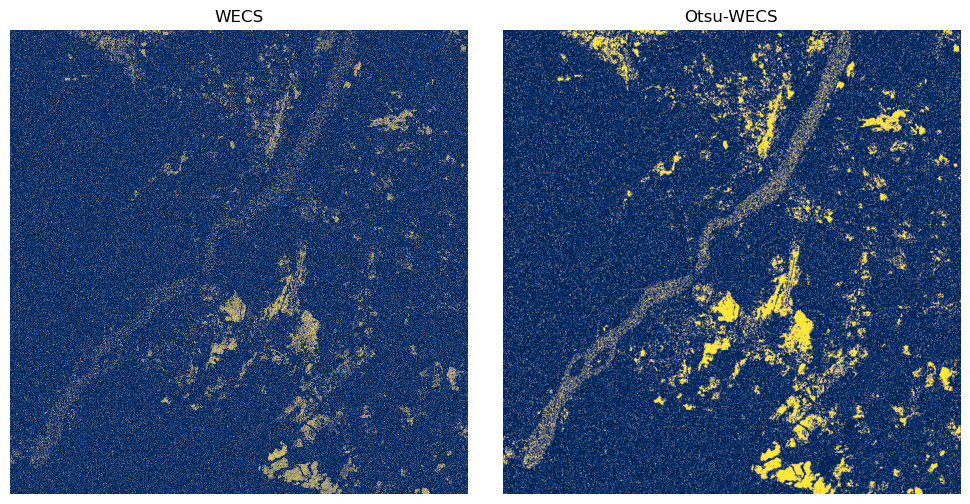

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(wecs, cmap='cividis', interpolation='nearest')
axes[0].set_title('WECS')
axes[0].axis('off')  
axes[1].imshow(classified_wecs, cmap='cividis')
axes[1].set_title('Otsu-WECS')
axes[1].axis('off')

plt.tight_layout()
plt.show()